In [175]:
# # load 하기. 
# content_orig_total 파일은 data_collect 디렉토리의 get_dart.ipynb에서 생성해야 함.
import pickle
with open("content_orig_total.pickle", "rb") as fp:   # Unpickling the original xml file
  content_orig_total = pickle.load(fp)
len(content_orig_total)

2599

In [176]:
list(content_orig_total[0].keys())


['주식 코드', 'report_idx', '기업 코드', '기업 이름', '수정 일자', 'original_xml', 'contents']

In [177]:
from bs4 import BeautifulSoup
from pathos.pools import ProcessPool
import tqdm.notebook as tq

In [178]:
# 완성품 아래 코드를 복사해서 실제 코드에 옮긴다.
from dart_prcs import *

def preprocess(text):
    try:
        text = re.sub("&cr;", " ", text)
        text = re.sub("\n", "", text) 
        text = re.sub("\"", "", text)
        text = re.sub("\'", "", text)
        text = re.sub("-", "", text)
        text = re.sub("\"", "", text)
        text = re.sub("\'", "", text)
        text = re.sub(",", "", text)
        text = re.sub("(주)", "", text)
        text = re.sub("[(]", " (", text)
        text = re.sub("[)]", ") ", text)
        text = remove_repeated_spacing(text)
        text = clean_punc(text)
        text = remove_useless_breacket(text)
        text = remove_email(text)
        text = remove_url(text)
        text = re.sub('[■\.:%/~㈜&※·→①②$③○-ㆍ」「■>Ⅱ④;▶●?⑤社⑥⑦□=ㅇ『』外<◆△【】現▲▷美∼用☞@前㎡◇中Ⅲ－無新內％◈}株ㅁ會㎥{ㄱⅠ化高＋ㄴ日有：ㄷ公司全後限，〔〕學↑式月|＆ℓㄹ…業人名《》年^韓部▼本大小海│愛故食形㎏獨山多水東可非思州國家生上℃ㅂ合金發在同⊙軍英物實田開○○○○○作性體度産空分子光重ㅅ島間時利＂面母≪㎖資心別氣仁未京來對成雲淸聖命保的集史靑場法神正第一硏㎞ㅡ★太民如理出入下解得安平＝帝所市石門相方元政先富北木自車南地―｜求ㅎㅎ≫西長銀者規制女江福和ㅌ通主義村當代力㎝善原選色；古河──都能動歌〈〉不定ㅠ吉事理張數朝金㎜記書]'\
                      , " ", text)
    except:
        text = ""
    return text

def remove_table(soup):
    for t in soup.find_all('table'):
        t.decompose()
    assert len(soup.find_all('table')) == 0, "table still exists!"

def table_to_text(ss):
    # th: column name인데 간혹 "정 의" 이렇게 띄움. 이런 애들 띄어쓰기 제거
    for rm_t in ss.find_all('th'):
        try:
            rm_t.string.replace_with(re.sub(" ", "", rm_t.text))
        except AttributeError:
            # th안에 <p>제 20 기 3분기말</p>으로 들어가 있는데 얘들은 띄어쓰기 남겨둬야 해서 예외처리
            # try scope에서는 th안의 string 값 자체는 없어서 None으로 처리 됨.
            rm_t.string = rm_t.text
            pass
        except Exception as e:
            print(f"error: {e} in th tag\nerror in th: {rm_t}")
            # print(e)
            # print(rm_t)
            pass

    # 표 같은 경우 text 사이에 개행 / 띄어쓰기가 없음. 정규식 사용해서 전처리하면 다 붙어서 나옴.사 사이사이에 띄어쓰기 넣어줌.
    # exception: 간혹 태그 안에 태그 들어가 있고, 그 아래에 string 들어있음. 바깥으로 꺼내줘서 일관적으로 전처릭 먹도록. 여기에서 앞뒤로 띄어쓰기 넣어넣어줌
    # <td> 안에 <p>가 들어가 있음.

    tag_list = [ "tu", "td", "te", "th" ]
    for tl in tag_list:            
        for rm_t in ss.find_all(tl):
            try:
                rm_t.string.replace_with(" " + rm_t.string + " ")
            except AttributeError:
                # 없는 애들
                rm_t.string = " " + rm_t.text + " "
            except Exception as e: # there are tags with empty string value
                print(f"error: {e}in tu, td, te, th tag\nerror in th: {rm_t}")
                pass
    
    
def parse_content_from_xml(soup, rm_table : bool = True, feature = None):
    contents = {}
    feature_list = [None, "table_to_text", "passage", "passage_list"]
    assert feature in feature_list, f"feature must be either {str(feature_list)}"
    if rm_table:
        remove_table(soup)
        assert len(soup.find_all('table')) == 0, "table still exists!"

    for s in soup.find_all("section-1"):
        title = str(s.title.string)
        sub_chapters = {}
        for ss in s.find_all("section-2"):
            clean_text = None
            sub_title = str(ss.title.string)
            if feature == "table_to_text":
                table_to_text(ss)
                clean_text = str(ss.get_text())
                
            elif feature == "passage":
                psgs_tag = ss.find_all("p")
                psgs = ""
                for p in psgs_tag:
                    psgs += ( " " +p.get_text() )
                clean_text = psgs
                
            elif feature == "passage_list":
                psgs_tag = ss.find_all("p")
                psgs = []
                for p in psgs_tag:
                    pp = p.get_text()
                    if pp: # p tag안에 내용 있을 때
                        psgs.append( pp )
                # clean_text = " ".join(psgs)
                clean_text = psgs
            else:
                clean_text = str(ss.get_text())

            sub_chapters[sub_title] = clean_text
        contents[title] = sub_chapters
    return contents

def parallel_parse_report(cont,rm_table : bool = True, feature = None):
    # print("cleanse_content start")
    def _cleanse(c):
        try:
            soup = BeautifulSoup(c['original_xml'], "lxml")
            c['clean'] = parse_content_from_xml(soup, feature = feature)
        except Exception as e:
            print(e)
            print("cleanse_content error")
            print(cont['기업 이름'])
            c['clean'] = None

    if isinstance(cont, list):
        for c in cont:
            _cleanse(c)
    else:
        # print(cont)
        _cleanse(cont)
    return cont

In [179]:
tmp = content_orig_total[:10] # 10개만 해봅니다. 병렬화 없이!

for t in tq.tqdm( tmp ):
    res = parallel_parse_report(t, feature = "passage_list")
type(res)
res.keys()

# 뜯어보기
# for k , v in res['clean'].items():
#     print("Big ch: ", k)
#     for kk, vv in v.items():
#         print("small ch: ", kk)
#         # print(type(vv))
#         # print(vv)
#         for vvv in vv:
#             print(vvv)
#             print()
#         print()
    

  0%|          | 0/10 [00:00<?, ?it/s]

dict_keys(['주식 코드', 'report_idx', '기업 코드', '기업 이름', '수정 일자', 'original_xml', 'contents', 'clean'])

In [180]:
# cleanse을 passage list으로 실행
import pandas as pd
from functools import partial
tmp = content_orig_total

clean_conts = []
LIMIT = len(tmp) // 10
for i in tq.tqdm(range(0, len(tmp), LIMIT)): # to expect time per LIMIT
    try:
        pool = ProcessPool()
        res = pool.map( partial(parallel_parse_report, feature = "passage_list"), tmp[i:i+LIMIT] )
        clean_conts.extend( res )
    except Exception as e:
        print("error in cleanse contents: ",e)

  0%|          | 0/11 [00:00<?, ?it/s]

In [181]:
# clean_conts[0]

In [182]:
# 금융업과 제조업은 사업의 개요가 다른 이름이다.
alt_name = [ '1. (제조서비스업)사업의 개요', '1. (금융업)사업의 개요' ]
for c in tq.tqdm( clean_conts ):
    # print( type(c) )
    try:
        for k, v in c['clean'].items():
            try: # there are content in big chapter
                for kk, vv in v.items():
                    try: 
                        alt_idx = alt_name.index(kk)
                        del v[alt_name[alt_idx]]
                        # 여기 딕셔너리 concat되도록하자
                        if "1. 사업의 개요" in v.keys(): 
                            v["1. 사업의 개요"] += vv 
                        else:
                            v["1. 사업의 개요"] = vv
                    except: # when there are no alt name, but the name is "사업의 개요"
                        pass
            except: # whene there are no contents in big chapter
                # print(v)
                pass
    except: # whene there are no contents in big chapter
    # print(v)
        pass

  0%|          | 0/2599 [00:00<?, ?it/s]

In [183]:
df = pd.DataFrame(clean_conts)
df_context_mod = df['clean'].map(str)

In [184]:
# dataset2 = load_dataset("nlpHakdang/beneficiary", data_files = "dart_v2_1.csv", use_auth_token= "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")

df_v2 = pd.read_csv('dart_v2_1.csv')
df_v2_list = df_v2['corp_name'].to_list()
# df[df_v2['corp_name'] in df_v2_list]

df_orig = pd.DataFrame()
for i in range(len(df_v2_list)):
    df_orig = df_orig.append(df[df['기업 이름'] == df_v2_list[i]])

In [185]:
df_orig = df_orig.reset_index()
del df_orig['index']
df_orig

,주식 코드,report_idx,기업 코드,기업 이름,수정 일자,original_xml,contents,clean
0,950130,20211115000151,00956028,엑세스바이오,20170630,"<?xml version=""1.0"" encoding=""utf-8""?><html><b...","{'【 대표이사 등의 확인 】': {}, 'I. 회사의 개요': {'1. 회사의 개...","{'【 대표이사 등의 확인 】': {}, 'I. 회사의 개요': {'1. 회사의 개..."
1,900070,20211125000049,00783246,글로벌에스엠,20170703,"<?xml version=""1.0"" encoding=""utf-8""?><html><b...","{'【 대표이사 등의 확인 】': {}, 'I. 회사의 개요': {'1. 회사의 개...","{'【 대표이사 등의 확인 】': {}, 'I. 회사의 개요': {'1. 회사의 개..."
2,900120,20211028000448,00800084,씨케이에이치,20170703,"<?xml version=""1.0"" encoding=""utf-8""?><html><b...","{'【 대표이사 등의 확인 】': {}, 'I. 회사의 개요': {'1. 회사의 개...","{'【 대표이사 등의 확인 】': {}, 'I. 회사의 개요': {'1. 회사의 개..."
3,900290,20211028000456,01170962,GRT,20181122,"<?xml version=""1.0"" encoding=""utf-8""?><html><b...","{'【 대표이사 등의 확인 】': {}, 'I. 회사의 개요': {'1. 회사의 개...","{'【 대표이사 등의 확인 】': {}, 'I. 회사의 개요': {'1. 회사의 개..."
4,900340,20210830000685,01328639,윙입푸드,20181130,"<?xml version=""1.0"" encoding=""utf-8""?><html><b...","{'【 대표이사 등의 확인 】': {}, 'I. 회사의 개요': {'1. 회사의 개...","{'【 대표이사 등의 확인 】': {}, 'I. 회사의 개요': {'1. 회사의 개..."
...,...,...,...,...,...,...,...,...
2309,017800,20211115002172,00164724,현대엘리베이터,20210512,"<?xml version=""1.0"" encoding=""utf-8""?><html><b...","{'【 대표이사 등의 확인 】': {}, 'I. 회사의 개요': {'1. 회사의 개...","{'【 대표이사 등의 확인 】': {}, 'I. 회사의 개요': {'1. 회사의 개..."
2310,003410,20211115002437,00138224,쌍용씨앤이,20211020,"<?xml version=""1.0"" encoding=""utf-8""?><html><b...","{'【 대표이사 등의 확인 】': {}, 'I. 회사의 개요': {'1. 회사의 개...","{'【 대표이사 등의 확인 】': {}, 'I. 회사의 개요': {'1. 회사의 개..."
2311,015760,20211115001967,00159193,한국전력공사,20210602,"<?xml version=""1.0"" encoding=""utf-8""?><html><b...","{'【 대표이사 등의 확인 】': {}, 'I. 회사의 개요': {'1. 회사의 개...","{'【 대표이사 등의 확인 】': {}, 'I. 회사의 개요': {'1. 회사의 개..."
2312,900140,20211126000686,00838500,엘브이엠씨,20210611,"<?xml version=""1.0"" encoding=""utf-8""?><html><b...","{'【 대표이사 등의 확인 】': {}, 'I. 회사의 개요': {'1. 회사의 개...","{'【 대표이사 등의 확인 】': {}, 'I. 회사의 개요': {'1. 회사의 개..."


In [186]:
df_orig = df_orig.drop_duplicates(['기업 이름'], keep='first')
df_orig = df_orig.reset_index()
df_orig

,index,주식 코드,report_idx,기업 코드,기업 이름,수정 일자,original_xml,contents,clean
0,0,950130,20211115000151,00956028,엑세스바이오,20170630,"<?xml version=""1.0"" encoding=""utf-8""?><html><b...","{'【 대표이사 등의 확인 】': {}, 'I. 회사의 개요': {'1. 회사의 개...","{'【 대표이사 등의 확인 】': {}, 'I. 회사의 개요': {'1. 회사의 개..."
1,1,900070,20211125000049,00783246,글로벌에스엠,20170703,"<?xml version=""1.0"" encoding=""utf-8""?><html><b...","{'【 대표이사 등의 확인 】': {}, 'I. 회사의 개요': {'1. 회사의 개...","{'【 대표이사 등의 확인 】': {}, 'I. 회사의 개요': {'1. 회사의 개..."
2,2,900120,20211028000448,00800084,씨케이에이치,20170703,"<?xml version=""1.0"" encoding=""utf-8""?><html><b...","{'【 대표이사 등의 확인 】': {}, 'I. 회사의 개요': {'1. 회사의 개...","{'【 대표이사 등의 확인 】': {}, 'I. 회사의 개요': {'1. 회사의 개..."
3,3,900290,20211028000456,01170962,GRT,20181122,"<?xml version=""1.0"" encoding=""utf-8""?><html><b...","{'【 대표이사 등의 확인 】': {}, 'I. 회사의 개요': {'1. 회사의 개...","{'【 대표이사 등의 확인 】': {}, 'I. 회사의 개요': {'1. 회사의 개..."
4,4,900340,20210830000685,01328639,윙입푸드,20181130,"<?xml version=""1.0"" encoding=""utf-8""?><html><b...","{'【 대표이사 등의 확인 】': {}, 'I. 회사의 개요': {'1. 회사의 개...","{'【 대표이사 등의 확인 】': {}, 'I. 회사의 개요': {'1. 회사의 개..."
...,...,...,...,...,...,...,...,...,...
2308,2309,017800,20211115002172,00164724,현대엘리베이터,20210512,"<?xml version=""1.0"" encoding=""utf-8""?><html><b...","{'【 대표이사 등의 확인 】': {}, 'I. 회사의 개요': {'1. 회사의 개...","{'【 대표이사 등의 확인 】': {}, 'I. 회사의 개요': {'1. 회사의 개..."
2309,2310,003410,20211115002437,00138224,쌍용씨앤이,20211020,"<?xml version=""1.0"" encoding=""utf-8""?><html><b...","{'【 대표이사 등의 확인 】': {}, 'I. 회사의 개요': {'1. 회사의 개...","{'【 대표이사 등의 확인 】': {}, 'I. 회사의 개요': {'1. 회사의 개..."
2310,2311,015760,20211115001967,00159193,한국전력공사,20210602,"<?xml version=""1.0"" encoding=""utf-8""?><html><b...","{'【 대표이사 등의 확인 】': {}, 'I. 회사의 개요': {'1. 회사의 개...","{'【 대표이사 등의 확인 】': {}, 'I. 회사의 개요': {'1. 회사의 개..."
2311,2312,900140,20211126000686,00838500,엘브이엠씨,20210611,"<?xml version=""1.0"" encoding=""utf-8""?><html><b...","{'【 대표이사 등의 확인 】': {}, 'I. 회사의 개요': {'1. 회사의 개...","{'【 대표이사 등의 확인 】': {}, 'I. 회사의 개요': {'1. 회사의 개..."


In [187]:
df_orig['clean'][1641]['II. 사업의 내용'].keys()

dict_keys(['2. (제조서비스업)주요 제품 및 서비스', '3. (제조서비스업)원재료 및 생산설비', '4. (제조서비스업)매출 및 수주상황', '5. (제조서비스업)위험관리 및 파생거래', '6. (제조서비스업)주요계약 및 연구개발활동', '7. (제조서비스업)기타 참고사항', '2. (금융업)영업의 현황', '3. (금융업)파생상품거래 현황', '4. (금융업)영업설비', '5. (금융업)재무건전성 등 기타 참고사항', '1. 사업의 개요'])

In [188]:
df_context_mod = df_orig['clean'].map(str)

In [189]:
eval(df_context_mod[0])['I. 회사의 개요']['1. 회사의 개요']

['\n1. 연결대상 종속회사 개황(연결재무제표를 작성하는 주권상장법인이 사업보고서, 분기ㆍ반기보고서를 제출하는 경우에 한함)&cr;연결대상 종속회사 현황(요약)\n',
 '1-1. 연결대상회사의 변동내용',
 '\n2.  회사의 법적, 상업적 명칭&cr;당사의 명칭은 (주)엑세스바이오로 표기합니다. 영문으로는 Access Bio, Inc.로 표기합니다.&cr;&cr;\n3. 설립일자 및 존속기간&cr;설립일자 : 2002년 9월 27일&cr;존속기간 : 해당사항 없음&cr;\n',
 '\n4. 본사의 주소, 전화번호, 홈페이지 주소\n',
 '\n&cr;5. 중소기업 해당 여부 \n',
 '&cr;\n6. 대리인에 관한 사항&cr;공시 업무는 유진투자증권 주식회사가 진행하고 있습니다.\n',
 "    이   름 :  유진투자증권(주) &cr;    대표자 :  유창수&cr;    주   소 :  서울특별시 영등포구 국제금융로 24 유진그룹빌딩    &cr;    연락처 :  1588-6300&cr;&cr;\n7. 주요 사업의 내용 및 신규산업의 내용&cr;당사는 말라리아와 G6PD, 독감, 코로나 바이러스 등의 진단시약을 개발, 생산하는 업체로,회사의 사업은 작게는 현장진단검사(Point of Care Test : POCT) 시장에 속해 있고 크게는 체외진단(In-Vitro Diagnostics) 시장에 속해 있습니다.  &cr;상세한 내용은 동 공시서류의 '사업의 내용'을 참조하시기 바랍니다.  \n",
 '8. 회사의 주권상장(또는 등록ㆍ지정)여부 및 특례상장에 관한 사항']

In [190]:
df_corp, df_busi= [], []
error_corp = []

for i in range(len(df_context_mod)):
    try:
        if 'II. 사업의 내용' in eval(df_context_mod[i]).keys() and ('1. 사업의 개요' in eval(df_context_mod[i])['II. 사업의 내용'].keys()):
            df_corp.append(eval(df_context_mod[i])['I. 회사의 개요']['1. 회사의 개요'])
            df_busi.append(eval(df_context_mod[i])['II. 사업의 내용']['1. 사업의 개요'])
        else:
            error_corp.append(df_orig['기업 이름'][i])
           
    except:
            error_corp.append(df_orig['기업 이름'][i])
            pass


In [191]:
error_corp

[]

In [192]:
contexts = {'회사의 개요' : df_corp, '사업의 개요' : df_busi}
# 현대자동차 통합 안되어있다!

In [193]:
df_plus = pd.DataFrame(contexts)
df_plus

df_plus = pd.DataFrame(contexts)
result = pd.concat([df_orig, df_plus], axis=1)
del result['clean']
del result['contents']
del result['original_xml']

In [194]:
print(len(result))
result.head()

2313


,index,주식 코드,report_idx,기업 코드,기업 이름,수정 일자,회사의 개요,사업의 개요
0,0,950130,20211115000151,00956028,엑세스바이오,20170630,"[\n1. 연결대상 종속회사 개황(연결재무제표를 작성하는 주권상장법인이 사업보고서,...","[당사는 체외진단 기술을 토대로 면역화학진단, 바이오센서, 분자진단 기술을 기반으..."
1,1,900070,20211125000049,00783246,글로벌에스엠,20170703,"[\n1. 연결대상 종속회사 개황(연결재무제표를 작성하는 주권상장법인이 사업보고서,...","[지주회사(持株會社, Holding Company)란 다른 회사의 주식을 소유한 회..."
2,2,900120,20211028000448,00800084,씨케이에이치,20170703,"[&cr;(1) 연결대상 종속회사 개황연결대상 종속회사 현황(요약), (1)-1. ...",[\n가. 산업개황 및 전망&cr;당사의 매출과 이익은 중국 내에서의 건강식품 생산...
3,3,900290,20211028000456,01170962,GRT,20181122,"[가. 연결대상 종속회사 현황(요약), 1-1. 연결대상회사의 변동내용, &cr;\...","[\n가. 산업의 이해&cr;&cr;(1) 영위하고 있는 사업\n, 당사의 주요 사..."
4,4,900340,20210830000685,01328639,윙입푸드,20181130,[\n가. 연결대상 종속회사 개황&cr;&cr;1-1 연결대상 종속회사 현황(요약)...,[&cr; 당사는 한국 표준산업 분류 기준 대분류상 식료품 제조업 산업에 세분류상...


In [195]:
from copy import deepcopy
prcs_result = deepcopy(result)

cols = ['회사의 개요', '사업의 개요']
for c in tq.tqdm( cols ):
    
    one_col = prcs_result[c] # get the target column
    num_psgs = []
    for i, one_corp in enumerate( one_col ): # for each corp in one column
        if one_corp == None:
            continue
        prcs_psgs = []
        for psg in one_corp: # for each string in one corp
            prcs_psg = preprocess(psg)
            if prcs_psg: # remove empty string
                prcs_psgs.append( prcs_psg )
        one_col[i] = prcs_psgs
        # num_psg = len(one_corp)
        # num_psgs.append( num_psg )
print(len(prcs_result))
prcs_result.head()

  0%|          | 0/2 [00:00<?, ?it/s]

/opt/conda/envs/lightweight/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2313


,index,주식 코드,report_idx,기업 코드,기업 이름,수정 일자,회사의 개요,사업의 개요
0,0,950130,20211115000151,00956028,엑세스바이오,20170630,[1 연결대상 종속회사 개황 (연결재무제표를 작성하는 권상장법인이 사업보고서 분기...,[당사는 체외진단 기술을 토대로 면역화학진단 바이오센서 분자진단 기술을 기반으로 진...
1,1,900070,20211125000049,00783246,글로벌에스엠,20170703,[1 연결대상 종속회사 개황 (연결재무제표를 작성하는 권상장법인이 사업보고서 분기...,[지회사 (持 Holding Company) 란 다른 회사의 식을 소유한 회사...
2,2,900120,20211028000448,00800084,씨케이에이치,20170703,"[(1) 연결대상 종속회사 개황연결대상 종속회사 현황 (요약), (1) 1 연결대...",[가 산업개황 및 전망 당사의 매출과 이익은 중국 내에서의 건강식품 생산 및 판매...
3,3,900290,20211028000456,01170962,GRT,20181122,"[가 연결대상 종속회사 현황 (요약), 11 연결대상회사의 변동내용, 나 회사...","[가 산업의 이해 (1) 영위하고 있는 사업, 당사의 요 사업영역으로는 정밀 코팅..."
4,4,900340,20210830000685,01328639,윙입푸드,20181130,"[가 연결대상 종속회사 개황 11 연결대상 종속회사 현황 (요약), 12 연결대...",[당사는 한국 표준산업 분류 기준 대분류상 식료품 제조업 산업에 세분류상 가금류 가...


(array([ 70., 383., 342., 415., 266., 129., 151.,  69.,  50.,  55.,  32.,
         39.,  21.,  29.,  21.,  18.,  17.,  11.,  20.,  16.,   8.,   7.,
          6.,   6.,   7.,   5.,   8.,   8.,   1.,   8.,   4.,   5.,   9.,
          5.,   6.,   6.,   8.,   4.,   4.,   3.,   1.,   3.,   5.,   0.,
          3.,   1.,   1.,   1.,   0.,   2.,   0.,   0.,   4.,   0.,   2.,
          3.,   0.,   0.,   0.,   2.,   0.,   1.,   0.,   2.,   1.,   1.,
          1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   4.,   0.,   0.,   1.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,
          1.]),
 array([  4.  ,   6.61,   9.22,  11.83,  14.44,  17.05,  19.66,  22.27,
         24.88,  27.49,  30.1 ,  32.71,  35.32,  37.93,  40.54,  43.15,
         45.76,  48.37,  50.98,  53.59,  56.2 ,  58.81,  61.42,  64.03,
         66.64,  69.25,  71.86,  74.47,  77.08,  79.69,  82.3 ,  84.91,
         87.52,  90.13,  92.74

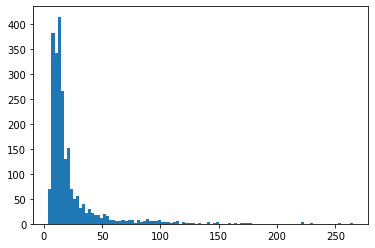

In [196]:
cols = ['회사의 개요', '사업의 개요']

num_data_per_corp = []

for row_idx in range( len(prcs_result) ):
    corp = prcs_result.iloc[row_idx]
    
    num_psg_per_corp = 0
    for col in cols:
        psg_list = corp[col]
        
        if psg_list == None:
            continue
        num_psg_per_sm_ch = len( psg_list )
        num_psg_per_corp += num_psg_per_sm_ch
    num_data_per_corp.append( num_psg_per_corp )

import matplotlib.pyplot as plt
fig,ax = plt.subplots(1)
ax.hist(num_data_per_corp, bins = 100)

In [197]:
cols = ['회사의 개요', '사업의 개요']

df_expansion = []
from copy import deepcopy

new_corp_list = []

for row_idx in tq.tqdm( range( len(prcs_result) ) ):
    corp = prcs_result.iloc[row_idx]

    all_psg_list_per_corp = []
    
    len_psg_per_corp = []
    for col in cols:

        psg_list = corp[col]
        
        if psg_list == None:
            continue
            
        # for each passage
        for psg in psg_list:
            all_psg_list_per_corp.append( psg )
    
    for i in range(len(all_psg_list_per_corp)):
        copy_corp = deepcopy(corp)
        copy_corp['passage'] = all_psg_list_per_corp[i]
    
        new_corp_list.append( copy_corp )
df_expansion = pd.DataFrame(new_corp_list)


for col in cols:
    del df_expansion[col]
df_expansion.head()

  0%|          | 0/2313 [00:00<?, ?it/s]

,index,주식 코드,report_idx,기업 코드,기업 이름,수정 일자,passage
0,0,950130,20211115000151,00956028,엑세스바이오,20170630,1 연결대상 종속회사 개황 (연결재무제표를 작성하는 권상장법인이 사업보고서 분기 ...
0,0,950130,20211115000151,00956028,엑세스바이오,20170630,11 연결대상회사의 변동내용
0,0,950130,20211115000151,00956028,엑세스바이오,20170630,2 회사의 법적 상업적 명칭 당사의 명칭은 엑세스바이오로 표기합니다 영문으로는...
0,0,950130,20211115000151,00956028,엑세스바이오,20170630,4 본사의 소 전화번호 홈페이지 소
0,0,950130,20211115000151,00956028,엑세스바이오,20170630,5 중소기업 해당 여부


In [198]:
len(df_expansion)

51785

In [199]:
# df_expansion.to_csv("dart_v3_2.csv")